## Analyze surface fields to estimate small scale gradients

We want to address the questions of whether the small scale surface variance/fronts are enhanced in the summer or winter? 

A first guess might be that more fronts are present in the winter because of deeper mixed layers creating small scale flows, which can stir up a lot of fronts. 

However, this is a bit contradictory to turbulence theory, in which a steeper spectra of surface velocity field (less variance at small scales) leads to a flatter spectrum of passive tracers. This would suggest that in winter when there is more kinetic energy at small scales, we might expect a steeper tracer spectrum. 

However, there are further questions about this thinking. Firstly, temperature is not entirely a passive tracer. Secondly, a statement about the spectral slope does not say much about the actual variance at small scales. 

We try to look at what LLC4320 (~1-2km) simulation tells us about this. 

If we see patterns that are similar to obs, then it would suggest that we could focus on understanding the mechanisms that generate the small scale variability using the model fields. 

In [1]:
import dask
dask.config.set({"logging.distributed": "warning"})

In [2]:
# # Setup cluster
from dask_gateway import GatewayCluster
from dask.distributed import Client
cluster = GatewayCluster()
cluster.scale(5)
client = Client(cluster)
cluster

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Load some useful modules 
import numpy as np
import xarray as xr
import xrft
import intake
from xmitgcm import llcreader
from matplotlib import pyplot as plt

%matplotlib inline

In [5]:
cat_url = "https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/llc4320.yaml"
cat = intake.open_catalog(cat_url)

In [6]:
# Get variables from catalog
sst = cat.LLC4320_SST.to_dask()
sss = cat.LLC4320_SSS.to_dask()
ssh = cat.LLC4320_SSH.to_dask()
u = cat.LLC4320_SSU.to_dask()
v = cat.LLC4320_SSV.to_dask()

In [7]:
ds = xr.merge([ssh, sst, sss, u, v])
ds = llcreader.llcmodel.faces_dataset_to_latlon(ds, metric_vector_pairs=[])
ds

,Array,Chunk
Bytes,7.36 TiB,71.19 MiB
Shape,"(9030, 12960, 17280)","(1, 4320, 4320)"
Count,659191 Tasks,108360 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,7.36 TiB,71.19 MiB
Shape,"(9030, 12960, 17280)","(1, 4320, 4320)"
Count,659191 Tasks,108360 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [8]:
coords = cat.LLC4320_grid.to_dask().reset_coords()
coords

<xarray.Dataset>
Dimensions:  (face: 13, j: 4320, i: 4320, k_p1: 2, j_g: 4320, i_g: 4320,
              time: 9030)
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * k_p1     (k_p1) int64 0 1
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-09-23T05:00:00
Data variables: (12/30)
    CS       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    Depth    (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    PHrefC   float32 ...
    PHrefF   (k_p1) float32 dask.array<chunksize=(2,), meta=np.ndarray>
    SN       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    XC       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    ...       ...
    k_l      int64 ...
    k_u      int64 ...
    rA       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    rAs      (face, j_g, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    rAw      (face, j, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    rAz      (face, j_g, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      Created by calling `open_mdsdataset(llc_method='smallchunks...
    source:       MITgcm
    title:        netCDF wrapper of MITgcm MDS binary data

In [9]:
coords = llcreader.llcmodel.faces_dataset_to_latlon(coords) # Transform a 13-face LLC xarray Dataset into a rectancular grid, discarding the Arctic.
coords

<xarray.Dataset>
Dimensions:  (face: 13, i: 17280, i_g: 17280, j: 12960, j_g: 12960, k_p1: 2,
              time: 9030)
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
  * i_g      (i_g) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
  * j        (j) int64 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959
  * j_g      (j_g) int64 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959
  * k_p1     (k_p1) int64 0 1
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-09-23T05:00:00
Data variables: (12/30)
    CS       (j, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    Depth    (j, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    PHrefC   float32 15.4
    PHrefF   (k_p1) float32 dask.array<chunksize=(2,), meta=np.ndarray>
    SN       (j, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    XC       (j, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    ...       ...
    rAw      (j, i_g) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    rAz      (j_g, i_g) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    dxC      (j, i_g) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    dyC      (j_g, i) float32 dask.array<chunksize=(1, 4320), meta=np.ndarray>
    dyG      (j, i_g) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    dxG      (j_g, i) float32 dask.array<chunksize=(1, 4320), meta=np.ndarray>

In [10]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [11]:
import xgcm
grid = xgcm.Grid(coords.drop(['k', 'k_p1']), periodic=None)

In [12]:
grid

<xgcm.Grid>
Y Axis (not periodic, boundary=None):
  * center   j --> left
  * left     j_g --> center
T Axis (not periodic, boundary=None):
  * center   time
X Axis (not periodic, boundary=None):
  * center   i --> left
  * left     i_g --> center

### Define anomalies and small scale variance

Show how we detect small scale variance.

In [13]:
sel_sogos = np.logical_and(np.logical_and(coords.XC>28, coords.XC<40 ), 
                           np.logical_and(coords.YC>-56, coords.YC<-48 ))

In [14]:
%%time
SST_sogos = ds.SST.where(sel_sogos, drop=True)

CPU times: user 1.15 s, sys: 307 ms, total: 1.46 s
Wall time: 2min 23s


In [15]:
SST_sogos

<xarray.DataArray 'SST' (time: 9030, j: 660, i: 576)>
dask.array<where, shape=(9030, 660, 576), dtype=float32, chunksize=(1, 660, 576), chunktype=numpy.ndarray>
Coordinates:
  * i        (i) int64 3168 3169 3170 3171 3172 ... 3739 3740 3741 3742 3743
  * j        (j) int64 4410 4411 4412 4413 4414 ... 5065 5066 5067 5068 5069
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-09-23T05:00:00

In [16]:
# area averaged mean, with some time points dropped for faster calc
#SST_sogos_av_monthly = SST_sogos.isel(
#        time=slice(0,9030,15*24)).mean(['i','j'])


In [17]:
SST_sogos_av_monthly = SST_sogos.coarsen(
        time=15*24, boundary='trim').mean().mean(['i','j'])

In [18]:
%%time
SST_sogos_av_monthly.load();

CPU times: user 7.19 s, sys: 551 ms, total: 7.74 s
Wall time: 10min 44s


<xarray.DataArray 'SST' (time: 25)>
array([1.8606133, 1.8318803, 1.9614545, 2.2964044, 2.4245708, 2.692324 ,
       3.4751747, 3.7680397, 3.8377378, 4.110159 , 4.358824 , 4.328542 ,
       4.196997 , 4.0536227, 3.8840587, 3.535464 , 3.2548378, 2.9680507,
       2.6161468, 2.398334 , 2.1700945, 2.081016 , 2.0680513, 1.914912 ,
       1.8882748], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2011-09-20T11:30:00 ... 2012-09-14T11:30:00

In [19]:
lwindow = 40 # do a rolling box avg over 40 grid points 
SST_sogos_ls = (SST_sogos.rolling(i=lwindow, center=True).mean()
                   ).rolling(j=lwindow, center=True).mean()
SST_sogos_ss = SST_sogos - SST_sogos_ls

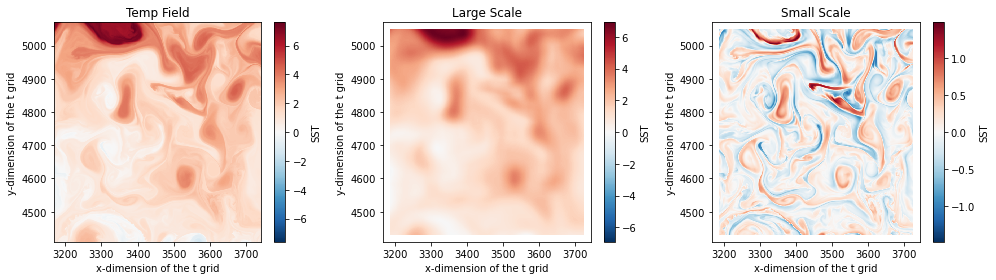

In [23]:
plt.figure(figsize=(14,4))
plt.subplot(131)
SST_sogos.isel(time=0).plot()
plt.title('Temp Field')

plt.subplot(132)
SST_sogos_ls.isel(time=0).plot()
plt.title('Large Scale')

plt.subplot(133)
SST_sogos_ss.isel(time=0).plot()
plt.title('Small Scale')
plt.tight_layout()

plt.savefig('method.png')

In [62]:
# Seasonal cycle of small scale variance
SST_sogos_ss_monthly = SST_sogos_ss.isel(
           time=slice(0,9030,15*24)).var(['i','j'])

In [61]:
SST_sogos_ss_monthly

<xarray.DataArray 'SST' (time: 26)>
dask.array<mean_agg-aggregate, shape=(26,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2011-09-13 2011-09-28 ... 2012-09-22

In [63]:
# # Seasonal cycle of small scale variance
# SST_sogos_ss_monthly = SST_sogos_ss.isel(
#             time=slice(0,9030,15*24)).coarsen(
#             time=7*24, boundary='trim').std(['i','j'])
# # .var().var(['i','j'])

In [65]:
%%time
SST_sogos_ss_monthly.load();

CPU times: user 43.2 s, sys: 19.3 s, total: 1min 2s
Wall time: 34.1 s


<xarray.DataArray 'SST' (time: 26)>
array([0.09286161, 0.08726384, 0.07170692, 0.07036822, 0.05410518,
       0.04829612, 0.04622801, 0.0494363 , 0.04774985, 0.06120339,
       0.07927695, 0.07654496, 0.06439814, 0.05546105, 0.06922472,
       0.05764808, 0.05621395, 0.0567898 , 0.04865244, 0.04804132,
       0.0519872 , 0.05666542, 0.06544424, 0.06436335, 0.06919407,
       0.07590174])
Coordinates:
  * time     (time) datetime64[ns] 2011-09-13 2011-09-28 ... 2012-09-22

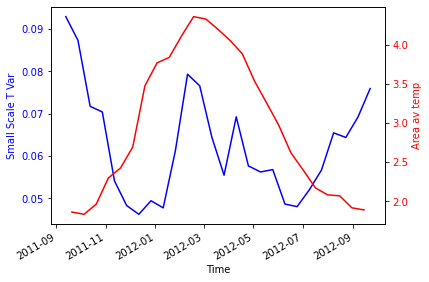

In [66]:
fig, ax1 = plt.subplots()
SST_sogos_ss_monthly.plot(ax=ax1,color='b')
ax1.set_ylabel('Small Scale T Var', color='b')
ax1.tick_params(axis='y', labelcolor='b')

ax2= ax1.twinx()
SST_sogos_av_monthly.plot(ax=ax2, color='r');
ax2.set_ylabel('Area av temp',color='r')
ax2.tick_params(axis='y', labelcolor='r')

#plt.savefig('method2.png')

## Apply method to larger regions

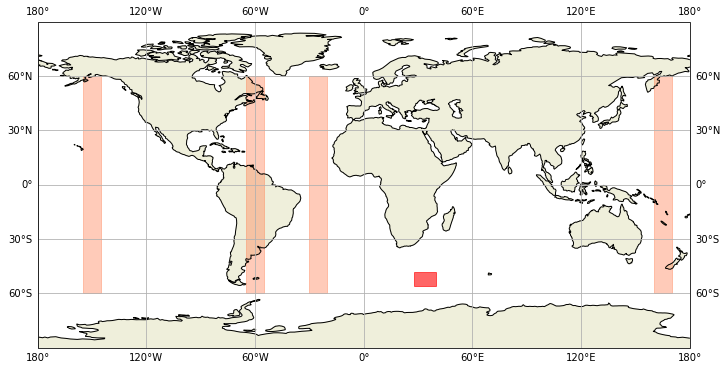

In [67]:
#x, y = [-44, -44, 45, 45, -44], [-45, box_top, box_top, -45, -45]

x_east, y_east = [160, 170, 170, 160, 160], [-60, -60, 60, 60, -60]
x_west, y_west = [-155, -145, -145, -155, -155], [-60, -60, 60, 60, -60]
x_atl_east, y_atl_east = [-30, -20, -20, -30, -30], [-60, -60, 60, 60, -60]
x_atl_west, y_atl_west = [-65, -55, -55, -65, -65], [-60, -60, 60, 60, -60]

x_sogos, y_sogos = [28, 40, 40, 28, 28], [-56, -56, -48, -48, -48]

plt.figure(figsize=(14,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()

#ax.plot(x, y, marker='o', transform=ccrs.PlateCarree())
ax.fill(x_east, y_east, color='coral', transform=ccrs.PlateCarree(), alpha=0.4)
ax.fill(x_west, y_west, color='coral', transform=ccrs.PlateCarree(), alpha=0.4)

ax.fill(x_atl_east, y_atl_east, color='coral', transform=ccrs.PlateCarree(), alpha=0.4)
ax.fill(x_atl_west, y_atl_west, color='coral', transform=ccrs.PlateCarree(), alpha=0.4)

ax.fill(x_sogos, y_sogos, color='red', transform=ccrs.PlateCarree(), alpha=0.6)


ax.coastlines()
ax.set_boundary
ax.add_feature(cfeature.LAND)
ax.gridlines(draw_labels=True);

plt.savefig('regions.png')

#### Pacific

x_east, y_east = [160, 170, 170, 160, 160], [-60, -60, 60, 60, -60]  
x_west, y_west = [-155, -145, -145, -155, -155], [-60, -60, 60, 60, -60]

In [68]:
sel_Pac_strip_west = np.logical_and(np.logical_and(coords.XC>160, coords.XC<170 ),
                           np.logical_and(coords.YC>-60, coords.YC<60 ))
sel_Pac_strip_east = np.logical_and(np.logical_and(coords.XC>-155, coords.XC<-145 ),
                           np.logical_and(coords.YC>-60, coords.YC<60 ))

In [69]:
# Pacific Strip 
SST_Pac_strip_west = ds.SST.where(sel_Pac_strip_west, drop=True)
SST_Pac_strip_east = ds.SST.where(sel_Pac_strip_east, drop=True)

In [70]:
SST_Pac_strip_west

<xarray.DataArray 'SST' (time: 9030, j: 7764, i: 484)>
dask.array<where, shape=(9030, 7764, 484), dtype=float32, chunksize=(1, 4320, 484), chunktype=numpy.ndarray>
Coordinates:
  * i        (i) int64 9504 9505 9506 9507 9508 ... 9983 9984 9985 9986 9987
  * j        (j) int64 4040 4041 4042 4043 4044 ... 11800 11801 11802 11803
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-09-23T05:00:00

In [71]:
SST_Pac_strip_west_monthly = SST_Pac_strip_west.isel(
    time=slice(0,9030,15*24)).coarsen(j=450, boundary='trim').mean().mean(['i'])
SST_Pac_strip_east_monthly = SST_Pac_strip_east.isel(
    time=slice(0,9030,15*24)).coarsen(j=450, boundary='trim').mean().mean(['i'])

In [72]:
YCmean_Pac_strip_coarse = coords.YC.where(sel_Pac_strip_west, drop=True
                                         ).coarsen(j=450, boundary='trim').mean().mean(['i'])

In [73]:
%%time
YCmean_Pac_strip_coarse.load()

CPU times: user 1.19 s, sys: 282 ms, total: 1.47 s
Wall time: 527 ms


<xarray.DataArray 'YC' (j: 17)>
array([-57.593563 , -52.436527 , -46.722225 , -40.411068 , -33.50311  ,
       -26.028343 , -18.053455 ,  -9.684051 ,  -1.0619241,   7.5935664,
        16.039183 ,  24.12173  ,  31.72638  ,  38.776978 ,  45.235065 ,
        51.093918 ,  56.38883  ], dtype=float32)
Coordinates:
  * j        (j) float64 4.264e+03 4.714e+03 5.164e+03 ... 1.101e+04 1.146e+04

In [83]:
YCmean_Pac_strip_coarse

<xarray.DataArray 'YC' (j: 17)>
array([-57.593563 , -52.436527 , -46.722225 , -40.411068 , -33.50311  ,
       -26.028343 , -18.053455 ,  -9.684051 ,  -1.0619241,   7.5935664,
        16.039183 ,  24.12173  ,  31.72638  ,  38.776978 ,  45.235065 ,
        51.093918 ,  56.38883  ], dtype=float32)
Coordinates:
  * j        (j) float64 4.264e+03 4.714e+03 5.164e+03 ... 1.101e+04 1.146e+04

In [74]:
%%time
SST_Pac_strip_west_monthly.load();
SST_Pac_strip_east_monthly.load();

CPU times: user 39.8 s, sys: 20.4 s, total: 1min
Wall time: 36.4 s


<xarray.DataArray 'SST' (time: 26, j: 17)>
array([[ 0.24675633,  6.3465977 ,  8.109035  , 11.170293  , 15.957353  ,
        21.334307  , 25.370039  , 26.41938   , 26.126469  , 27.241943  ,
        25.620512  , 24.779943  , 24.380005  , 21.241976  , 15.040731  ,
        11.6113615 , 10.641459  ],
       [ 0.49969527,  6.671501  ,  8.198674  , 11.187257  , 15.899507  ,
        21.815275  , 25.584387  , 26.370096  , 26.070984  , 27.203987  ,
        25.603521  , 25.041368  , 24.345201  , 19.007969  , 12.604534  ,
        10.352357  ,  9.990281  ],
       [ 0.38933557,  6.4521885 ,  8.128069  , 11.222593  , 15.858732  ,
        21.530712  , 25.62732   , 26.65102   , 25.91049   , 27.067375  ,
        25.535404  , 24.917803  , 23.558125  , 17.946465  , 11.398832  ,
         9.224123  ,  8.669102  ],
       [ 0.54537135,  6.5744305 ,  8.583899  , 12.629969  , 17.988176  ,
        22.36866   , 25.482649  , 26.81068   , 25.97561   , 27.140638  ,
        25.332598  , 24.33408   , 22.346174  , 17.18243   , 10.87773   ,
         7.8432636 ,  7.231113  ],
       [ 0.71111995,  6.8261094 ,  9.16923   , 12.54786   , 17.626284  ,
        23.48417   , 26.13991   , 26.932577  , 25.733738  , 27.121922  ,
        25.016577  , 23.549908  , 21.103573  , 15.96191   , 10.025621  ,
         6.6246896 ,  5.994837  ],
...
       [ 0.3455658 ,  6.8799953 ,  8.7607155 , 11.833084  , 16.244652  ,
        20.869955  , 25.516056  , 27.723785  , 27.596985  , 27.052502  ,
        24.749674  , 23.261417  , 22.04712   , 19.796604  , 14.477347  ,
         9.798196  ,  9.850076  ],
       [ 0.27973518,  6.652534  ,  8.561572  , 11.55802   , 16.00589   ,
        20.585295  , 25.443066  , 27.789669  , 27.535059  , 27.31057   ,
        24.809595  , 23.485964  , 23.213734  , 21.361063  , 15.452039  ,
        10.974662  , 10.757727  ],
       [ 0.28587288,  6.757024  ,  8.50643   , 11.419132  , 15.704817  ,
        20.29956   , 25.349333  , 27.647745  , 27.430721  , 27.469501  ,
        25.168139  , 24.010324  , 24.323225  , 21.608772  , 15.593021  ,
        11.767222  , 11.317067  ],
       [ 0.19508572,  6.508447  ,  8.364724  , 11.378383  , 15.904422  ,
        20.251553  , 24.97739   , 27.504005  , 27.188017  , 27.745022  ,
        25.150251  , 23.861727  , 23.473318  , 21.996675  , 16.520123  ,
        11.9331255 , 10.691339  ],
       [ 0.29709578,  6.569403  ,  8.378762  , 11.24006   , 15.628416  ,
        20.465034  , 25.820885  , 27.591005  , 26.945818  , 27.696623  ,
        25.343811  , 24.013172  , 23.459639  , 21.260462  , 15.821283  ,
        11.473277  ,  9.845335  ]], dtype=float32)
Coordinates:
  * j        (j) float64 4.264e+03 4.714e+03 5.164e+03 ... 1.101e+04 1.146e+04
  * time     (time) datetime64[ns] 2011-09-13 2011-09-28 ... 2012-09-22

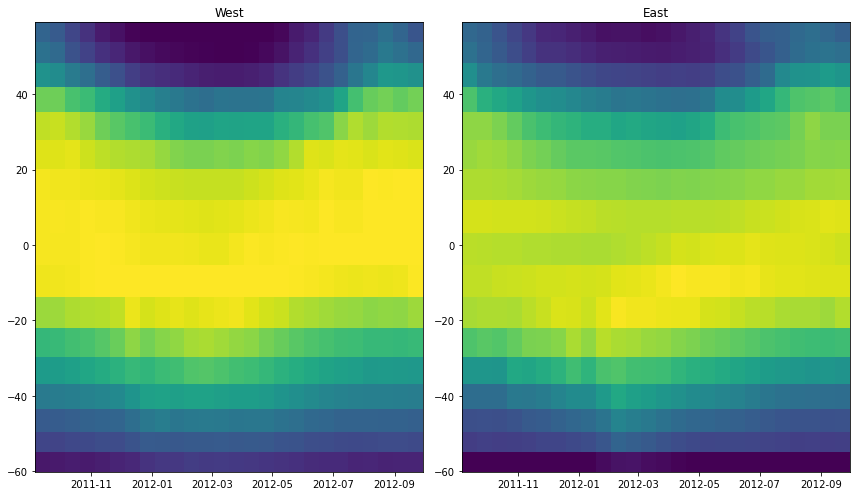

In [75]:
# Seasonal cycle of temp
plt.figure(figsize=(12,7))

plt.subplot(121)
plt.pcolormesh(SST_Pac_strip_west_monthly.time,
               YCmean_Pac_strip_coarse, 
               SST_Pac_strip_west_monthly.T, 
              vmin=1.5, vmax=29)
plt.title('West')

plt.subplot(122)
plt.pcolormesh(SST_Pac_strip_east_monthly.time,
               YCmean_Pac_strip_coarse, 
               SST_Pac_strip_east_monthly.T,
              vmin=1.5, vmax=29)
plt.title('East')
plt.tight_layout()

In [76]:
lwindow = 40
SST_Pac_strip_west_ls = (SST_Pac_strip_west.rolling(i=lwindow, center=True).mean()
                   ).rolling(j=lwindow, center=True).mean();
SST_Pac_strip_east_ls = (SST_Pac_strip_east.rolling(i=lwindow, center=True).mean()
                   ).rolling(j=lwindow, center=True).mean();

In [77]:
SST_Pac_strip_west_ss = SST_Pac_strip_west - SST_Pac_strip_west_ls
SST_Pac_strip_east_ss = SST_Pac_strip_east - SST_Pac_strip_east_ls

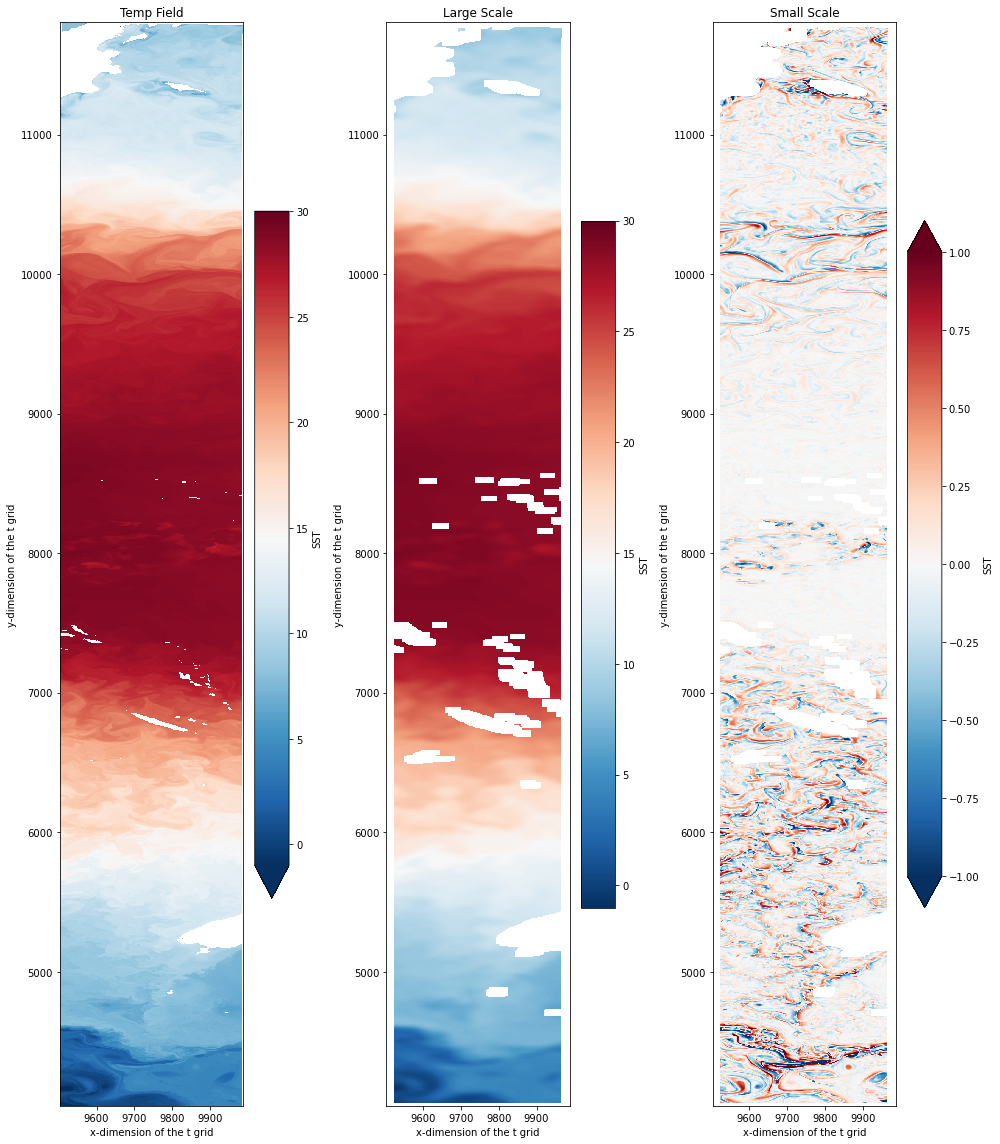

In [78]:
# West Snapshot
plt.figure(figsize=(14,16))
plt.subplot(131)
SST_Pac_strip_west.isel(time=0).plot(vmin=-1, vmax=30, cmap='RdBu_r')
plt.title('Temp Field')

plt.subplot(132)
SST_Pac_strip_west_ls.isel(time=0).plot(vmin=-1, vmax=30, cmap='RdBu_r')
plt.title('Large Scale')

plt.subplot(133)
SST_Pac_strip_west_ss.isel(time=0).plot(vmin=-1, vmax=1, cmap='RdBu_r')
plt.title('Small Scale')
plt.tight_layout()

distributed.scheduler - INFO - Retire worker names (178,)
distributed.deploy.adaptive - INFO - Retiring workers [178]
distributed.scheduler - INFO - Remove worker tcp://10.32.55.16:36429
distributed.core - INFO - Removing comms to tcp://10.32.55.16:36429
distributed.scheduler - INFO - Retire worker names (179, 180, 181, 182, 183, 184, 185, 186)
distributed.deploy.adaptive - INFO - Retiring workers [179, 180, 181, 182, 183, 184, 185, 186]
distributed.scheduler - INFO - Remove worker tcp://10.32.13.15:34255
distributed.core - INFO - Removing comms to tcp://10.32.13.15:34255
distributed.scheduler - INFO - Remove worker tcp://10.32.9.16:41507
distributed.core - INFO - Removing comms to tcp://10.32.9.16:41507
distributed.scheduler - INFO - Remove worker tcp://10.32.15.16:37387
distributed.core - INFO - Removing comms to tcp://10.32.15.16:37387
distributed.scheduler - INFO - Remove worker tcp://10.32.15.17:32823
distributed.core - INFO - Removing comms to tcp://10.32.15.17:32823
distributed.

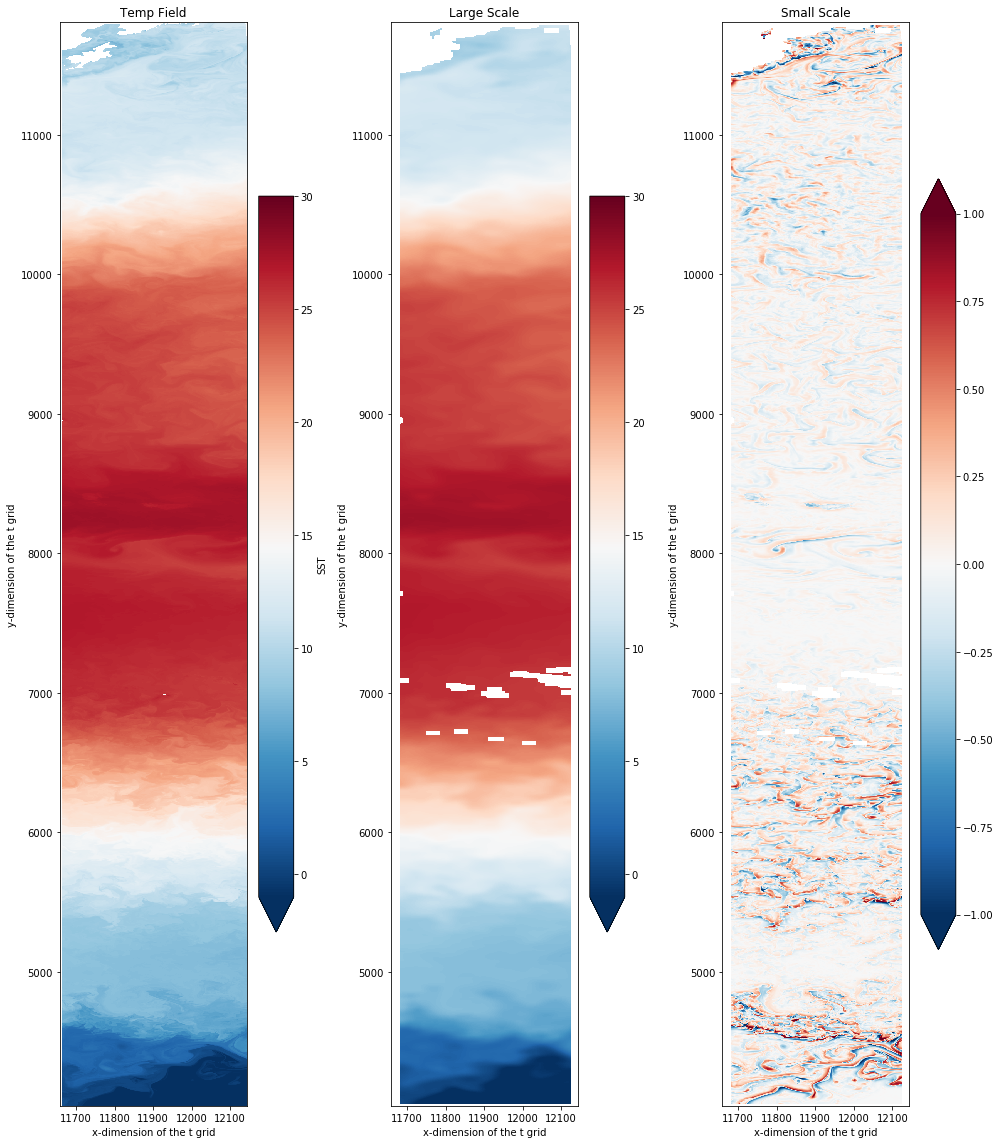

In [99]:
# East Snapshot
plt.figure(figsize=(14,16))
plt.subplot(131)
SST_Pac_strip_east.isel(time=0).plot(vmin=-1, vmax=30, cmap='RdBu_r')
plt.title('Temp Field')

plt.subplot(132)
SST_Pac_strip_east_ls.isel(time=0).plot(vmin=-1, vmax=30, cmap='RdBu_r')
plt.title('Large Scale')

plt.subplot(133)
SST_Pac_strip_east_ss.isel(time=0).plot(vmin=-1, vmax=1, cmap='RdBu_r')
plt.title('Small Scale')
plt.tight_layout()

In [79]:
# estimate the spatial variance 
SST_Pac_strip_west_ss_var = SST_Pac_strip_west_ss.isel(time=slice(0,9030,24*5)
                                ).coarsen(j=450, boundary='trim').std().std(['i'])
SST_Pac_strip_east_ss_var = SST_Pac_strip_east_ss.isel(time=slice(0,9030,24*5)
                                ).coarsen(j=450, boundary='trim').std().std(['i'])

In [80]:
%%time
SST_Pac_strip_west_ss_var.load();

CPU times: user 7min 49s, sys: 2min 54s, total: 10min 43s
Wall time: 5min 7s


<xarray.DataArray 'SST' (time: 76, j: 17)>
array([[0.09312451, 0.1023128 , 0.0562398 , ..., 0.04088792, 0.04564092,
        0.09405708],
       [0.10202223, 0.14024636, 0.05386809, ..., 0.03517237, 0.04939963,
        0.07622771],
       [0.14085681, 0.110444  , 0.05915456, ..., 0.03112581, 0.06692719,
        0.06622305],
       ...,
       [0.10588793, 0.08272455, 0.03745378, ..., 0.02733851, 0.06768671,
        0.07753473],
       [0.13493528, 0.08073643, 0.03642223, ..., 0.03948001, 0.07807613,
        0.07510717],
       [0.14200787, 0.1024874 , 0.03940791, ..., 0.04599426, 0.06966941,
        0.06983419]])
Coordinates:
  * j        (j) float64 4.264e+03 4.714e+03 5.164e+03 ... 1.101e+04 1.146e+04
  * time     (time) datetime64[ns] 2011-09-13 2011-09-18 ... 2012-09-22

In [81]:
%%time
SST_Pac_strip_east_ss_var.load()

CPU times: user 8min 19s, sys: 1min 34s, total: 9min 53s
Wall time: 4min 12s


<xarray.DataArray 'SST' (time: 76, j: 17)>
array([[0.05914564, 0.04137672, 0.03093934, ..., 0.03153371, 0.01250589,
        0.04173396],
       [0.06831937, 0.04348838, 0.03158797, ..., 0.03835641, 0.01522458,
        0.03444403],
       [0.07317435, 0.05281757, 0.03150348, ..., 0.03197292, 0.01692528,
        0.04510119],
       ...,
       [0.0882846 , 0.05740067, 0.01983249, ..., 0.01964538, 0.02058427,
        0.04936986],
       [0.09686139, 0.07663851, 0.01779398, ..., 0.02015557, 0.01668267,
        0.04641196],
       [0.0944133 , 0.08059709, 0.01830975, ..., 0.01834803, 0.01083149,
        0.04048503]])
Coordinates:
  * j        (j) float64 4.264e+03 4.714e+03 5.164e+03 ... 1.101e+04 1.146e+04
  * time     (time) datetime64[ns] 2011-09-13 2011-09-18 ... 2012-09-22

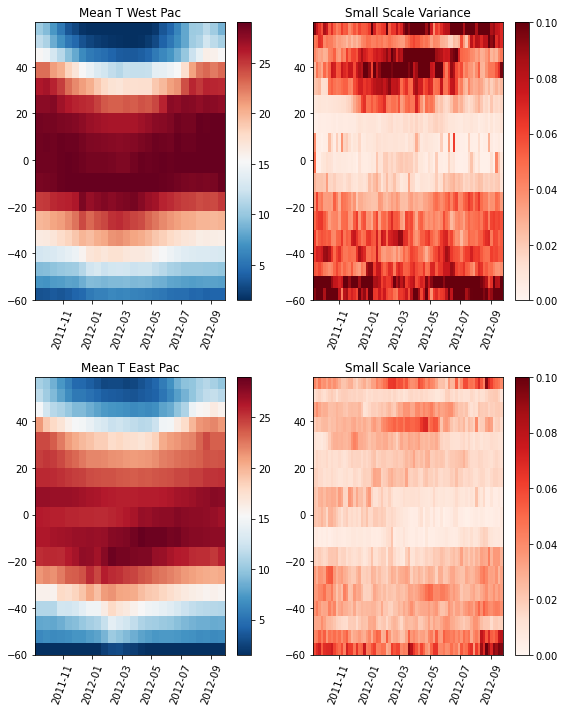

In [84]:
plt.figure(figsize=(8,10))

plt.subplot(221)
plt.pcolormesh(SST_Pac_strip_west_monthly.time,
               YCmean_Pac_strip_coarse, 
               SST_Pac_strip_west_monthly.T,
              vmin=1.5, vmax=29, cmap='RdBu_r')
plt.xticks(rotation=70)
plt.colorbar()
plt.title('Mean T West Pac')
#(SST_Pac_strip_west_monthly.T).plot.contourf(levels=20)

plt.subplot(222)
plt.pcolormesh(SST_Pac_strip_west_ss_var.time,
               YCmean_Pac_strip_coarse, 
               SST_Pac_strip_west_ss_var.T,
              vmin=0, vmax=0.1, cmap='Reds')
plt.xticks(rotation=70)
plt.colorbar()
plt.title('Small Scale Variance')
#SST_Pac_small_scale_var_west.T.plot(vmax=0.3, cmap='Reds')

plt.subplot(223)
plt.pcolormesh(SST_Pac_strip_east_monthly.time,
              YCmean_Pac_strip_coarse, 
               SST_Pac_strip_east_monthly.T,
              vmin=1.5, vmax=29, cmap='RdBu_r')
plt.xticks(rotation=70)
plt.colorbar()
plt.title('Mean T East Pac')
#(SST_Pac_strip_west_monthly.T).plot.contourf(levels=20)

plt.subplot(224)
plt.pcolormesh(SST_Pac_strip_east_ss_var.time,
               YCmean_Pac_strip_coarse, 
               SST_Pac_strip_east_ss_var.T,
              vmin=0, vmax=0.1, cmap='Reds')
plt.xticks(rotation=70)
plt.colorbar()
plt.title('Small Scale Variance')

plt.tight_layout()
plt.savefig('pac.png')

# Atlantic
x_atl_east, y_atl_east = [-30, -20, -20, -30, -30], [-60, -60, 60, 60, -60]  
x_atl_west, y_atl_west = [-65, -55, -55, -65, -65], [-60, -60, 60, 60, -60]


In [85]:
sel_Atl_strip_west = np.logical_and(np.logical_and(coords.XC>-30, coords.XC<-20 ),
                           np.logical_and(coords.YC>-60, coords.YC<60 ))
sel_Atl_strip_east = np.logical_and(np.logical_and(coords.XC>-65, coords.XC<-55 ),
                           np.logical_and(coords.YC>-60, coords.YC<60 ))

In [86]:
# Pacific Strip 
SST_Atl_strip_west = ds.SST.where(sel_Atl_strip_west, drop=True)
SST_Atl_strip_east = ds.SST.where(sel_Atl_strip_east, drop=True)

In [87]:
YCmean_Atl_strip_coarse = coords.YC.where(sel_Atl_strip_west, drop=True
                                         ).coarsen(j=450, boundary='trim').mean().mean(['i'])

In [88]:
%%time
YCmean_Atl_strip_coarse.load()

CPU times: user 1.1 s, sys: 520 ms, total: 1.62 s
Wall time: 509 ms


<xarray.DataArray 'YC' (j: 17)>
array([-57.593563 , -52.436527 , -46.722225 , -40.411068 , -33.50311  ,
       -26.028343 , -18.053455 ,  -9.684051 ,  -1.0619241,   7.5935664,
        16.039183 ,  24.12173  ,  31.72638  ,  38.776978 ,  45.235065 ,
        51.093918 ,  56.364105 ], dtype=float32)
Coordinates:
  * j        (j) float64 4.264e+03 4.714e+03 5.164e+03 ... 1.101e+04 1.146e+04

In [89]:
SST_Atl_strip_west_monthly = SST_Atl_strip_west.isel(
    time=slice(0,9030,15*24)).coarsen(j=450, boundary='trim').mean().mean(['i'])
SST_Atl_strip_east_monthly = SST_Atl_strip_east.isel(
    time=slice(0,9030,15*24)).coarsen(j=450, boundary='trim').mean().mean(['i'])

In [99]:
%%time
SST_Atl_strip_west_monthly.load();
SST_Atl_strip_east_monthly.load();

CPU times: user 193 µs, sys: 42 µs, total: 235 µs
Wall time: 240 µs


<xarray.DataArray 'SST' (time: 26, j: 17)>
array([[ 1.2671077 ,  4.455072  ,  5.385626  ,  7.4736066 , 10.99531   ,
                nan,         nan,         nan,         nan, 28.750244  ,
        28.630335  , 27.786888  , 27.698547  , 24.406794  , 16.64391   ,
        11.209531  ,  4.7745395 ],
       [ 1.0090724 ,  4.5458446 ,  5.5398154 ,  7.938693  , 12.343124  ,
                nan,         nan,         nan,         nan, 28.926874  ,
        28.578157  , 27.826565  , 27.564775  , 23.746416  , 15.097072  ,
         9.738282  ,  3.929605  ],
       [ 1.207636  ,  4.6779804 ,  6.1201854 ,  8.46983   , 13.698011  ,
                nan,         nan,         nan,         nan, 28.286129  ,
        28.381495  , 27.310612  , 25.997135  , 21.993969  , 12.608738  ,
         7.3622956 ,  2.9529438 ],
       [ 1.5272394 ,  5.157722  ,  6.870113  ,  9.227026  , 14.521547  ,
                nan,         nan,         nan,         nan, 28.387825  ,
        28.140112  , 27.019388  , 25.385807  , 21.04299   , 11.597978  ,
         7.0337014 ,  2.288955  ],
       [ 1.8846446 ,  6.0256186 ,  8.509078  , 10.997326  , 16.396936  ,
                nan,         nan,         nan,         nan, 28.221598  ,
        28.040981  , 26.876616  , 24.323803  , 19.583183  ,  9.668118  ,
         5.403434  ,  1.3955361 ],
...
       [ 1.6245091 ,  4.4929523 ,  5.680053  ,  7.32354   ,  9.340604  ,
                nan,         nan,         nan,         nan, 27.310389  ,
        27.718227  , 27.730867  , 27.145802  , 24.468962  , 17.404598  ,
        13.560414  ,  6.7953835 ],
       [ 1.5369875 ,  4.4013343 ,  5.5308867 ,  7.2440424 ,  9.640466  ,
                nan,         nan,         nan,         nan, 27.819971  ,
        27.878136  , 27.87687   , 27.59002   , 25.708467  , 19.243174  ,
        15.208394  ,  7.2845163 ],
       [ 1.459523  ,  4.376845  ,  5.503556  ,  7.3994393 , 11.292526  ,
                nan,         nan,         nan,         nan, 28.244537  ,
        28.00083   , 28.282846  , 28.644176  , 26.636385  , 20.52201   ,
        16.068672  ,  7.4524493 ],
       [ 1.3883873 ,  4.4656463 ,  5.525643  ,  7.468873  , 11.500853  ,
                nan,         nan,         nan,         nan, 28.110058  ,
        28.760399  , 27.57899   , 28.04949   , 25.176298  , 17.344904  ,
        14.767983  ,  6.7772703 ],
       [ 1.4375738 ,  4.605235  ,  5.914495  ,  7.945927  , 12.0929    ,
                nan,         nan,         nan,         nan, 28.199043  ,
        28.735035  , 28.150463  , 26.793537  , 24.30263   , 17.031046  ,
        12.962072  ,  4.820235  ]], dtype=float32)
Coordinates:
  * j        (j) float64 4.264e+03 4.714e+03 5.164e+03 ... 1.101e+04 1.146e+04
  * time     (time) datetime64[ns] 2011-09-13 2011-09-28 ... 2012-09-22

In [100]:
lwindow = 40
SST_Atl_strip_west_ls = (SST_Atl_strip_west.rolling(i=lwindow, center=True).mean()
                   ).rolling(j=lwindow, center=True).mean();
SST_Atl_strip_east_ls = (SST_Atl_strip_east.rolling(i=lwindow, center=True).mean()
                   ).rolling(j=lwindow, center=True).mean();

In [101]:
SST_Atl_strip_west_ss = SST_Atl_strip_west - SST_Atl_strip_west_ls
SST_Atl_strip_east_ss = SST_Atl_strip_east - SST_Atl_strip_east_ls

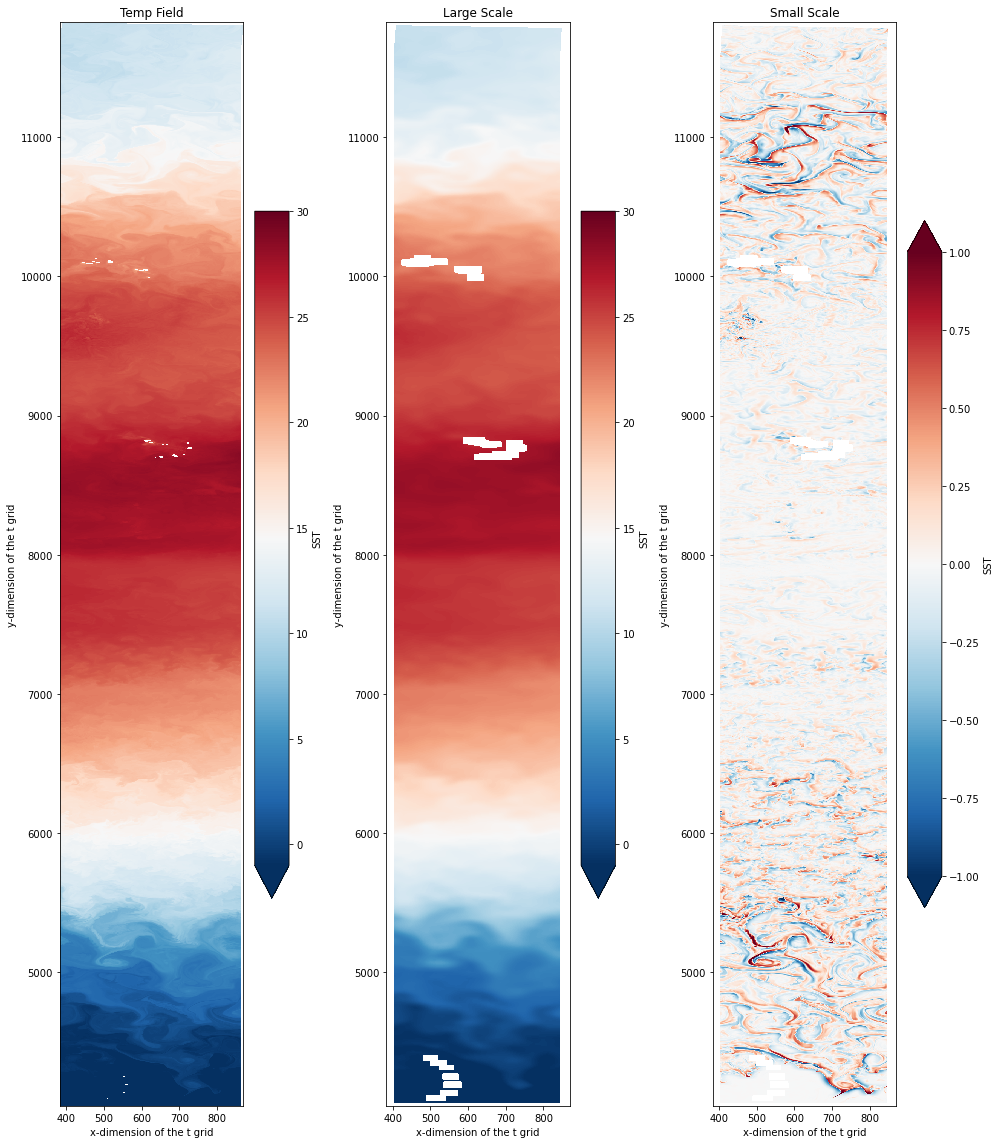

In [102]:
# West Natl Snapshot
plt.figure(figsize=(14,16))
plt.subplot(131)
SST_Atl_strip_west.isel(time=0).plot(vmin=-1, vmax=30, cmap='RdBu_r')
plt.title('Temp Field')

plt.subplot(132)
SST_Atl_strip_west_ls.isel(time=0).plot(vmin=-1, vmax=30, cmap='RdBu_r')
plt.title('Large Scale')

plt.subplot(133)
SST_Atl_strip_west_ss.isel(time=0).plot(vmin=-1, vmax=1, cmap='RdBu_r')
plt.title('Small Scale')
plt.tight_layout()

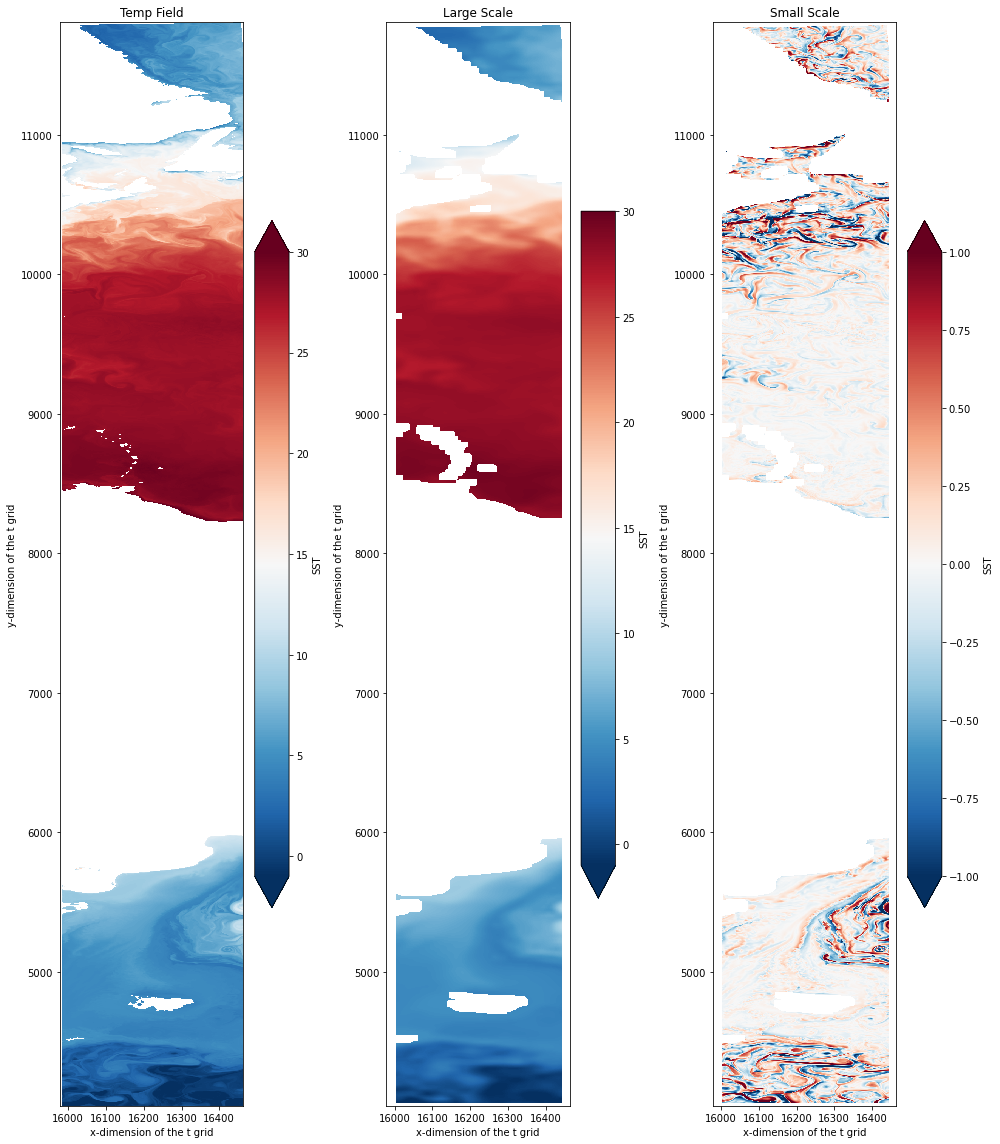

In [103]:
# East Natl Snapshot
plt.figure(figsize=(14,16))
plt.subplot(131)
SST_Atl_strip_east.isel(time=0).plot(vmin=-1, vmax=30, cmap='RdBu_r')
plt.title('Temp Field')

plt.subplot(132)
SST_Atl_strip_east_ls.isel(time=0).plot(vmin=-1, vmax=30, cmap='RdBu_r')
plt.title('Large Scale')

plt.subplot(133)
SST_Atl_strip_east_ss.isel(time=0).plot(vmin=-1, vmax=1, cmap='RdBu_r')
plt.title('Small Scale')
plt.tight_layout()

In [104]:
# estimate the spatial variance 
SST_Atl_strip_west_ss_var = SST_Atl_strip_west_ss.isel(time=slice(0,9030,24*5)
                                ).coarsen(j=450, boundary='trim').std().std(['i'])
SST_Atl_strip_east_ss_var = SST_Atl_strip_east_ss.isel(time=slice(0,9030,24*5)
                                ).coarsen(j=450, boundary='trim').std().std(['i'])

In [105]:
%%time
SST_Atl_strip_west_ss_var.load();

CPU times: user 6min 18s, sys: 1min 8s, total: 7min 27s
Wall time: 2min 13s


<xarray.DataArray 'SST' (time: 76, j: 17)>
array([[0.05050437, 0.03569605, 0.06930681, ..., 0.0467811 , 0.04757842,
        0.01778522],
       [0.0581705 , 0.03475308, 0.0635834 , ..., 0.06264641, 0.04137264,
        0.01683327],
       [0.05151181, 0.04813196, 0.07367729, ..., 0.045365  , 0.03602985,
        0.02829963],
       ...,
       [0.09413064, 0.03609467, 0.05845758, ..., 0.03103289, 0.02965691,
        0.01893695],
       [0.09410053, 0.06069423, 0.06653574, ..., 0.03163753, 0.03244408,
        0.03308497],
       [0.10362321, 0.05764035, 0.0667299 , ..., 0.03023167, 0.05702893,
        0.03047768]])
Coordinates:
  * j        (j) float64 4.264e+03 4.714e+03 5.164e+03 ... 1.101e+04 1.146e+04
  * time     (time) datetime64[ns] 2011-09-13 2011-09-18 ... 2012-09-22

In [106]:
%%time
SST_Atl_strip_east_ss_var.load();

CPU times: user 6min 10s, sys: 1min 6s, total: 7min 17s
Wall time: 2min 11s


<xarray.DataArray 'SST' (time: 76, j: 17)>
array([[0.07746192, 0.02873931, 0.13045377, ..., 0.13100851, 0.16662944,
        0.10365837],
       [0.06884461, 0.03197225, 0.12445216, ..., 0.13745274, 0.24227061,
        0.09493932],
       [0.07504954, 0.06741389, 0.16871481, ..., 0.09860321, 0.26366938,
        0.08443483],
       ...,
       [0.07631136, 0.04598217, 0.23641882, ..., 0.15632217, 0.09530956,
        0.1338596 ],
       [0.05842115, 0.05454526, 0.24140496, ..., 0.10725832, 0.0939747 ,
        0.12229464],
       [0.07183541, 0.03314376, 0.22688217, ..., 0.08246721, 0.14690363,
        0.09024084]])
Coordinates:
  * j        (j) float64 4.264e+03 4.714e+03 5.164e+03 ... 1.101e+04 1.146e+04
  * time     (time) datetime64[ns] 2011-09-13 2011-09-18 ... 2012-09-22

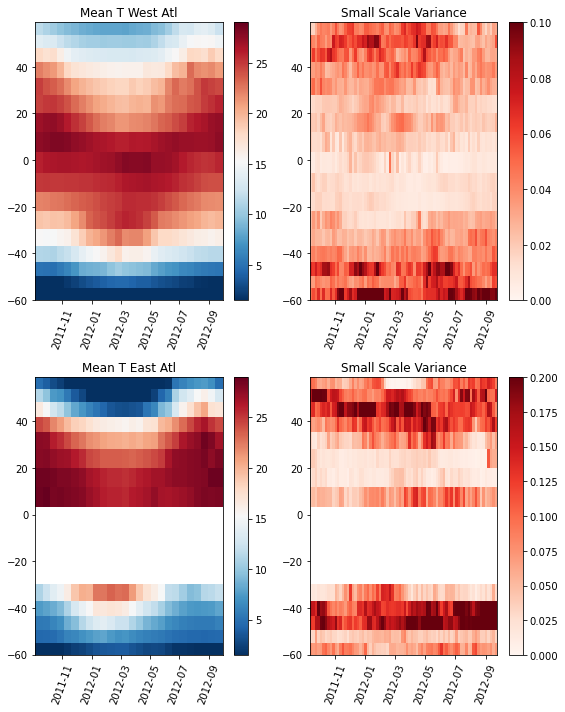

In [107]:
plt.figure(figsize=(8,10))

plt.subplot(221)
plt.pcolormesh(SST_Atl_strip_west_monthly.time,
               YCmean_Atl_strip_coarse, 
               SST_Atl_strip_west_monthly.T,
              vmin=1.5, vmax=29, cmap='RdBu_r')
plt.xticks(rotation=70)
plt.colorbar()
plt.title('Mean T West Atl')
#(SST_Pac_strip_west_monthly.T).plot.contourf(levels=20)

plt.subplot(222)
plt.pcolormesh(SST_Atl_strip_west_ss_var.time,
               YCmean_Atl_strip_coarse, 
               SST_Atl_strip_west_ss_var.T,
              vmin=0, vmax=0.1, cmap='Reds')
plt.xticks(rotation=70)
plt.colorbar()
plt.title('Small Scale Variance')
#SST_Pac_small_scale_var_west.T.plot(vmax=0.3, cmap='Reds')

plt.subplot(223)
plt.pcolormesh(SST_Atl_strip_east_monthly.time,
              YCmean_Atl_strip_coarse, 
               SST_Atl_strip_east_monthly.T,
              vmin=1.5, vmax=29, cmap='RdBu_r')
plt.xticks(rotation=70)
plt.colorbar()
plt.title('Mean T East Atl')
#(SST_Pac_strip_west_monthly.T).plot.contourf(levels=20)

plt.subplot(224)
plt.pcolormesh(SST_Atl_strip_east_ss_var.time,
               YCmean_Atl_strip_coarse, 
               SST_Atl_strip_east_ss_var.T,
              vmin=0, vmax=0.2, cmap='Reds')
plt.xticks(rotation=70)
plt.colorbar()
plt.title('Small Scale Variance')

plt.tight_layout()

plt.savefig('atl.png')